(256, 256)

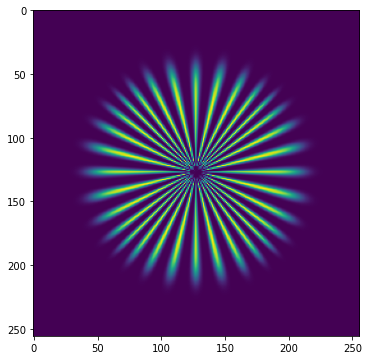

In [18]:
from skimage.io import imread
from tnia.plotting.plt_helper import imshow2d
from skimage.morphology import remove_small_holes


input_name = "D:\\images\\tnia-python-images\\notebooks\\deconvolution\\sinuosidal siemens star\\ref.tif"
#input_name = "D:\\images\\tnia-python-images\\notebooks\\deconvolution\\wheel\\wheel.tif"

star = imread(input_name)

fig=imshow2d(star)
img=star.astype('float32')
img.shape

(256, 256)


c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deconvolution\psfs.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  psf = fftshift(ifftn(ifftshift(otf)).astype(np.float32))


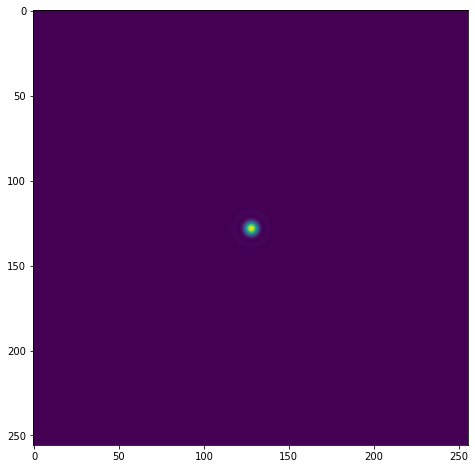

C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\matplotlib\_pylab_helpers.py:88: RuntimeWarning: coroutine 'get_msg' was never awaited
  gc.collect(1)


In [28]:
from tnia.deconvolution.psfs import paraxial_psf

n=img.shape[0]
wavelength = 500
na=1.4
pixel_size = 30

psf=paraxial_psf(n, wavelength, na, pixel_size)

print(psf.shape)
fig=imshow2d(psf,8,8)

In [29]:
from tnia.deconvolution.forward import forward

float32 float32 float32
0.99994814 358.0


c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deconvolution\forward.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  return poisson(field_imaged.astype(float))


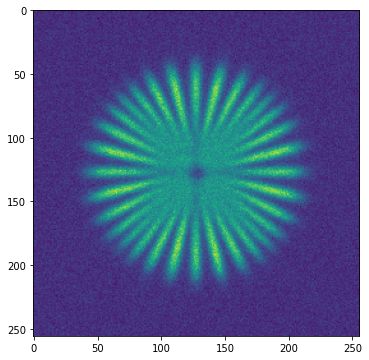

In [30]:
from tnia.nd.ndutil import centercrop2d
img = forward(star, psf,200.,100., True).astype('float32')

fig = imshow2d(img)
print(star.dtype, img.dtype, psf.dtype)
print(star.max(), img.max())

In [31]:
import numpy as np
from numpy.fft import fftn, ifftn, fftshift
from numpy.random import poisson

def richardson_lucy_np(image, psf, num_iters, save_interval):
    estimates=[]
    estimates.append(image)
    
    otf = fftn(fftshift(psf))
    otf_ = np.conjugate(otf)    
    estimate = image#np.ones(image.shape)/image.sum()

    for i in range(num_iters):
        #print(i)
        
        reblurred = ifftn(fftn(estimate) * otf)
        ratio = image / (reblurred + 1e-30)
        estimate = estimate * (ifftn(fftn(ratio) * otf_)).astype(float)
        
        if i%save_interval==0:
            print(i)
            estimates.append(estimate)
            
        
    return np.stack(estimates)

In [32]:
decons = richardson_lucy_np(img.astype('float64'), psf.astype('float64'), 500, 1)

C:\Users\bnort\AppData\Local\Temp\ipykernel_19728\2552754984.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  estimate = estimate * (ifftn(fftn(ratio) * otf_)).astype(float)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
from tnia.segmentation.filterobjects import find_circular_objects

In [34]:
from skimage.morphology import disk, closing, opening, square

def multi_otsu(im):

    bw = im>threshold_otsu(im)
    bw = im>threshold_otsu(im[bw>0])
    return bw


In [35]:
from skimage.filters import difference_of_gaussians
from skimage.morphology import closing, disk
from skimage.measure import label

def wheel_thresholder(im,sigma=3):
    bw=im>threshold_otsu(im)
    #bw=closing(bw,disk(3))

    test=difference_of_gaussians(bw.astype('uint8'),sigma)
    test[test<0]=0
    bw=test>threshold_otsu(test)
    return label(bw)



In [51]:
from numpy import matlib
truth=matlib.repeat(star[None,...],500,axis=0)
truth.shape
image=matlib.repeat(img[None,...],500,axis=0)
image.shape

(500, 256, 256)

In [52]:
from skimage.filters import threshold_otsu

otsus=[]
labels=[]
for i in range(decons.shape[0]):
    otsus.append(decons[i,:,:]>threshold_otsu(decons[i,:,:]))
    labels.append(wheel_thresholder(decons[i,:,:],2))
labels=np.stack(labels)  
otsus=np.stack(otsus)
import napari
viewer=napari.Viewer()
viewer.add_image(truth)
viewer.add_image(image)
viewer.add_image(decons)
viewer.add_labels(labels)
viewer.add_labels(otsus)



<Labels layer 'otsus' at 0x24474054820>

Exception in callback BaseAsyncIOLoop._handle_events(8544, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(8544, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\si

In [11]:
star=(255*star).astype('uint8')

In [12]:
star.min(), star.max(), star.dtype


(0, 254, dtype('uint8'))

In [14]:

#test=difference_of_gaussians(bw.astype('uint8'),1)
#test[test<0]=0
bw=test>threshold_otsu(test)
#bw=opening(bw, disk(1))
fig=imshow2d(label(bw))

NameError: name 'test' is not defined

In [ ]:
img.dtype, img.max(), img.min()

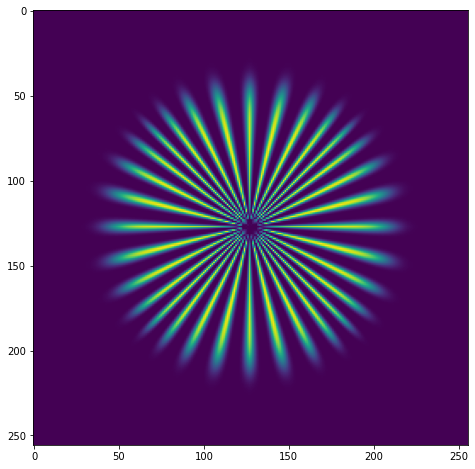

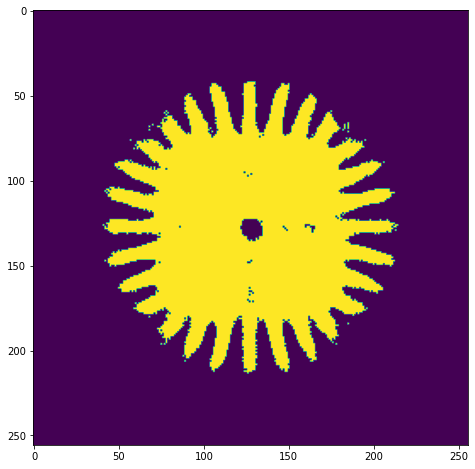

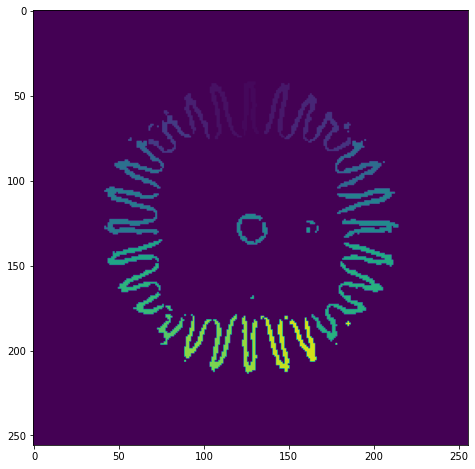

In [15]:
fig=imshow2d(star,8,8)
im=decons[250]
bw=im>threshold_otsu(im)
#bw=closing(bw,disk(1))
fig = imshow2d(bw,8,8)
dog=difference_of_gaussians(bw.astype('uint8'),1)
dog[dog<0]=0
bw=dog>threshold_otsu(dog)
#bw=opening(bw, disk(1))
fig=imshow2d(label(bw,connectivity=1),8,8)

In [17]:
viewer=napari.Viewer()
viewer.add_image(img)
viewer.add_image(bw)
viewer.add_labels(label(bw,connectivity=1))

C:\Users\bnort\AppData\Roaming\Python\Python39\site-packages\vispy\util\event.py:191: RuntimeWarning: coroutine 'get_msg' was never awaited
  self._blocked = {None: 0}


<Labels layer 'Labels' at 0x243ca12fdf0>

Exception in callback BaseAsyncIOLoop._handle_events(7116, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(7116, 1)>
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\tnia_deconware\lib\si

In [61]:
decon100 = richardson_lucy_np(img.astype('float64'), psf.astype('float64'), 100)

TypeError: richardson_lucy_np() missing 1 required positional argument: 'save_interval'

In [47]:
from skimage.measure import label, regionprops
from tnia.plotting.plt_helper import imshow_multi2d

i=10
im = decons[i]
bw = otsus[i]
bw = closing(bw,disk(1))
bw = opening(bw,disk(1))

labels=label(bw)

labels_filtered=find_circular_objects(im,labels,300,0,0)

fig=imshow_multi2d([labels, labels_filtered],['labels','labels filtered'],1,2)

ValueError: Label and intensity image shapes must match, except for channel (last) axis.

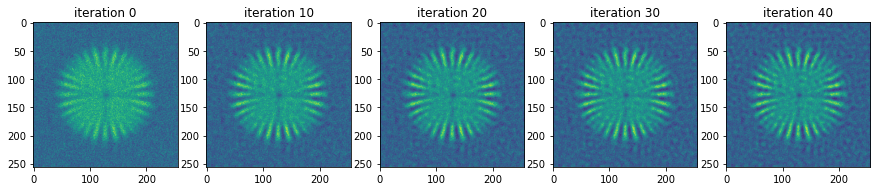

In [412]:
fig=imshow_multi2d(estimates, titles, 1,5,width=15, height=9)

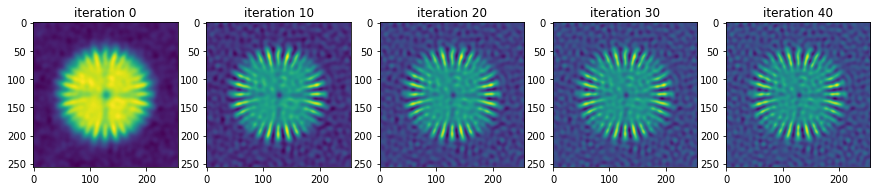

In [416]:
fig=imshow_multi2d(estimates, titles, 1,5,width=15, height=9)

In [410]:
len(titles)

10

In [411]:
len(estimates)

10